In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
%matplotlib inline

import sys
sys.path.append("/home/jonas/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")

import nanonets_utils
import nanonets

def scale_landscape(arr):
    return np.round((arr - np.min(arr,axis=0))/(np.max(arr,axis=0)-np.min(arr,axis=0)),2)

def autocorrelation(x : np.array, y : np.array, lags : int):

    return [np.corrcoef(x, y)[0,1] if l==0 else np.corrcoef(x[:-l], y[l:])[0,1] for l in range(lags)]

In [88]:
R_vals              = [50,100,200,400,800,1600,3200,6400,12800]
results_stat        = {}
states_stat         = {}
# net_currents_stat   = {}

for stat in range(1,11):
    stat = f"r{stat}"
    states          = {}
    # net_currents    = {}
    results         = pd.DataFrame()
    results["t"]    = np.loadtxt("1I_1O/time.csv")[1:]*10**9
    results["U"]    = pd.read_csv(f"/home/jonas/phd/data/1I_1O_R/R_50/{stat}/Nx=7_Ny=7_Nz=1_Ne=2.csv")['E0']

    for R_val in R_vals:

        results[f"I_R{R_val}"]      = pd.read_csv(f"/home/jonas/phd/data/1I_1O_R/R_{R_val}/{stat}/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
        results[f"uI_R{R_val}"]     = pd.read_csv(f"/home/jonas/phd/data/1I_1O_R/R_{R_val}/{stat}/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']
        states[f'R_{R_val}']        = pd.read_csv(f"/home/jonas/phd/data/1I_1O_R/R_{R_val}/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv")
        # net_currents[f'R_{R_val}']  = pd.read_csv(f"/home/jonas/phd/data/1I_1O_R/R_{R_val}/{stat}/net_currents_Nx=7_Ny=7_Nz=1_Ne=2.csv")
    
    results_stat[stat]  = results
    states_stat[stat]   = states

### Input - Output

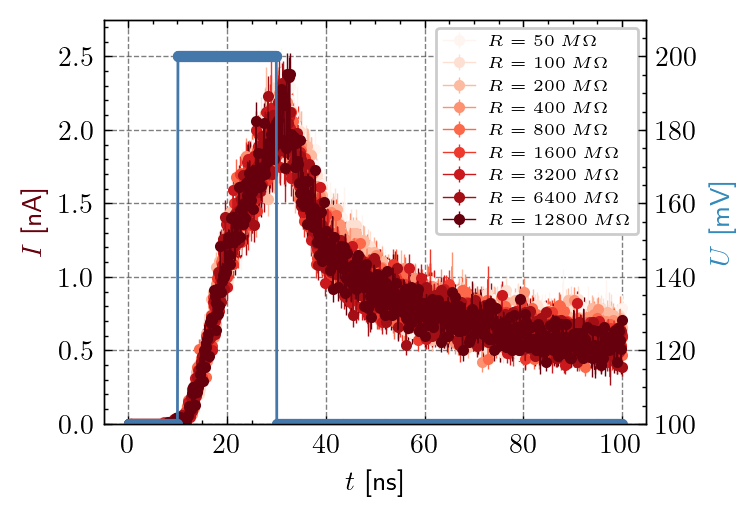

In [113]:
cmap    = plt.get_cmap('Reds')
R_vals  = [50,100,200,400,800,1600,3200,6400,12800]
stat    = 'r2'

with plt.style.context(["science", "bright", "grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for i, R_val in enumerate(R_vals):

        ax.errorbar(results_stat[stat]["t"], results_stat[stat][f'I_R{R_val}']/1000, results_stat[stat][f'uI_R{R_val}']/1000,
                    label=f'$R = {R_val}$ $M\Omega$', c=cmap(i/(len(R_vals)-1)), marker='.', markevery=2, lw=0.5)
        
    ax.legend(ncol=1, fontsize='xx-small')
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$I$ [nA]", c=cmap(i/(len(R_vals)-1)))
    ax.set_ylim(0,2.75)

    ax2 = ax.twinx()
    ax2.plot(results_stat[stat]["t"], results_stat[stat]['U']*1000, marker='.')
    ax2.grid(False)
    ax2.set_ylabel("$U$ [mV]", c=nanonets_utils.blue_color)
    ax2.set_ylim(100,210)

    fig.savefig(f"1I_1O_R_dis/plots/output_response_{stat}.svg", transparent=True, bbox_inches='tight')

# Vergleich zu exp Funktion

In [147]:
def model_func(t, A, K, C):
    return A * np.exp(K * t) + C

def fit_exp_linear(t, y, C=0):
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(t, y, 1)
    A = np.exp(A_log)
    return A, K

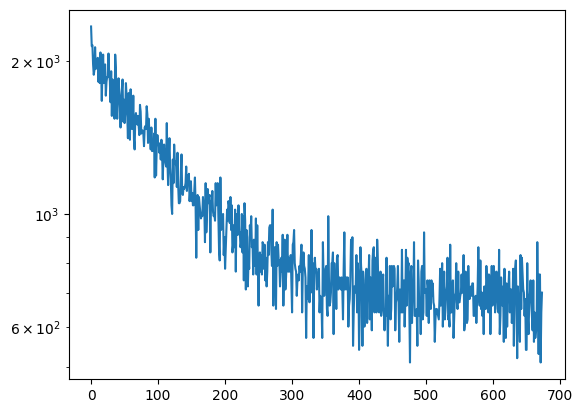

In [168]:
R_val   = 100
stat    = 'r10'

arr     = results_stat[stat][f'I_R{R_val}'].values
t       = results_stat[stat]["t"]

y       = arr[np.argmax(arr):]
t       = t[np.argmax(arr):]
C       = np.min(y)

# A, K    = fit_exp_linear(t, y, C)

plt.plot(y)
plt.yscale('log')
# plt.plot(model_func(t, A, K, C))

In [92]:
U_I_auto = {}

for stat in range(1,11):

    stat        = f"r{stat}"
    np_index    = np.arange(49)
    t           = results_stat[stat]["t"].values
    x           = results_stat[stat]["U"].values
    n_lags      = 300
    a_vals      = []

    for R in R_vals:
        a_vals.append(np.round(t[np.argmax(autocorrelation(x,results_stat[stat][f'I_R{R}'].values,n_lags))],2))

    U_I_auto[stat] = a_vals

/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


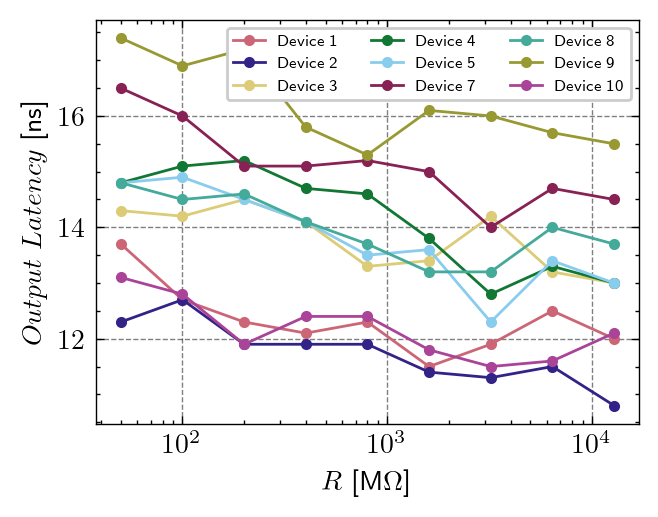

In [100]:
cmap = plt.get_cmap("Set3")

with plt.style.context(["science","muted", "grid"]):
    
    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for j, stat in enumerate([1,2,3,4,5,7,8,9,10]):

        stat_str = f"r{stat}"
        ax.plot(R_vals, U_I_auto[stat_str], marker='.', label=f'Device {stat}')
    
    ax.set_xscale('log')
    ax.set_ylabel('$Output$ $Latency$ [ns]')
    ax.set_xlabel('$R$ [M$\Omega$]')
    ax.legend(ncol=3, fontsize='xx-small')
    
    fig.savefig(f"1I_1O_R_dis/plots/output_latency.svg", transparent=True, bbox_inches='tight')

### Input - State

In [101]:
latency_stat = {}

for stat in range(1,11):

    stat        = f"r{stat}"
    np_index    = np.arange(49)
    t           = results_stat[stat]["t"].values
    x           = results_stat[stat]["U"].values
    n_lags      = 300
    latency     = {}

    for key, val in states_stat[stat].items():
        np_vals = []
        for j, i in enumerate(np_index): 
            np_vals.append(np.round(t[np.argmax(autocorrelation(x,val[f"{i}"].values,n_lags))],2))
        latency[key] = np_vals

    latency_stat[stat] = latency

/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


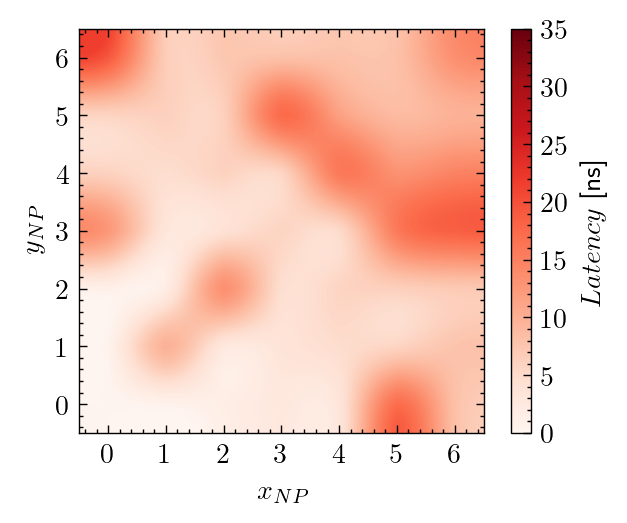

In [105]:
key     = 'R_100'
stat    = 'r9'

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    im  = ax.imshow(np.array(latency_stat[stat][key]).reshape(7,-1), cmap='Reds', origin='lower', vmin=0, vmax=35, interpolation='Spline16')
    fig.colorbar(im, label='$Latency$ [ns]')
    ax.set_xticks(np.arange(0,7))
    ax.set_yticks(np.arange(0,7))
    ax.set_xlabel("$x_{NP}$")
    ax.set_ylabel("$y_{NP}$")
    fig.savefig(f"1I_1O_R_dis/plots/network_latency_{key}_{stat}.svg", transparent=True, bbox_inches='tight')


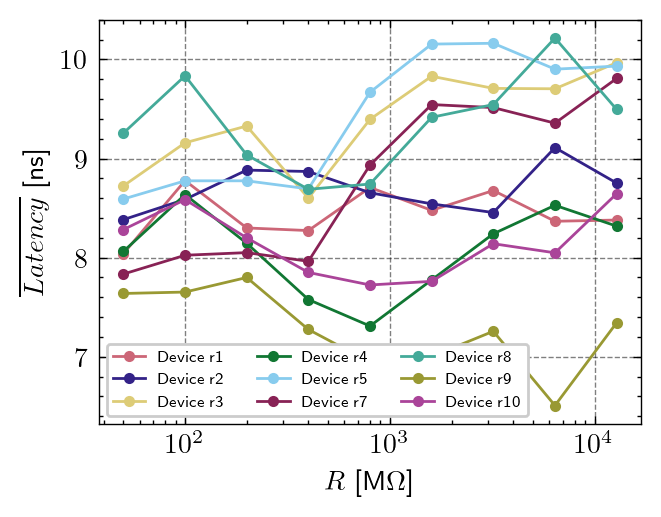

In [107]:
cmap = plt.get_cmap("Set3")

with plt.style.context(["science","muted", "grid"]):
    
    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for j, stat in enumerate([1,2,3,4,5,7,8,9,10]):

        stat = f"r{stat}"
        ax.plot(R_vals, [np.mean(latency_stat[stat][f'R_{i}']) for i in R_vals], marker='.', label=f'Device {stat}')
    
    ax.set_xscale('log')
    ax.set_ylabel('$\overline{Latency}$ [ns]')
    ax.legend(ncol=3, fontsize='xx-small')
    ax.set_xlabel('$R$ [M$\Omega$]')
    fig.savefig(f"1I_1O_R_dis/plots/avg_network_latency.svg", transparent=True, bbox_inches='tight')

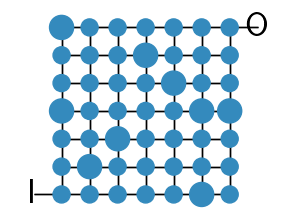

In [112]:
network_topology    = "cubic"
topology_parameter  = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[6,6,0]]
}

np_network_cubic    = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)
node_size           = np.repeat(150, 51)
seed                = 9
rs                  = np.random.RandomState(seed)

for i in rs.choice(np.arange(1,48), 9, replace=False):
    node_size[i] = 300

fig, ax = nanonets_utils.display_network(np_network_sim=np_network_cubic, node_size=node_size, provide_electrode_labels=["I","O"], font_size=25)
fig.savefig(f"1I_1O_R_dis/plots/network_plot_r{seed}.svg", transparent=True, bbox_inches='tight')

In [175]:
states_b        = {}
results_b       = pd.DataFrame()
results_b["t"]  = np.loadtxt("1I_1O/time.csv")[1:]*10**9
results_b["U"]  = pd.read_csv(f"1I_1O_R_dis/data/blocked/R_25/Nx=7_Ny=7_Nz=1_Ne=2.csv")['E0']

for R_val in [25,30,35,40,45]:

    results_b[f"I_R{R_val}"]    = pd.read_csv(f"1I_1O_R_dis/data/blocked/R_{R_val}/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
    results_b[f"uI_R{R_val}"]   = pd.read_csv(f"1I_1O_R_dis/data/blocked/R_{R_val}/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']
    states_b[f'R_{R_val}']      = pd.read_csv(f"1I_1O_R_dis/data/blocked/R_{R_val}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv")

25
30
35
40
45


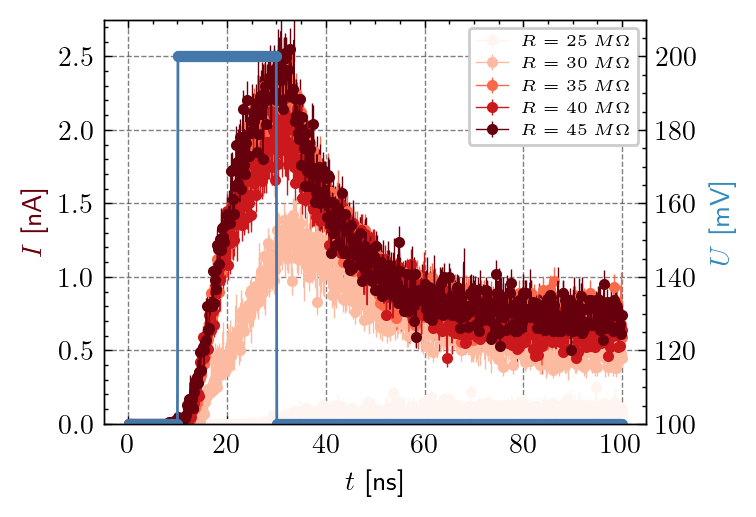

In [179]:
cmap    = plt.get_cmap('Reds')
R_vals  = [25,30,35,40,45]

with plt.style.context(["science", "bright", "grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for i, R_val in enumerate(R_vals):

        ax.errorbar(results_b["t"], results_b[f'I_R{R_val}']/1000, results_b[f'uI_R{R_val}']/1000,
                    label=f'$R = {R_val}$ $M\Omega$', c=cmap(i/(len(R_vals)-1)), marker='.', markevery=2, lw=0.5)
        
    ax.legend(ncol=1, fontsize='xx-small')
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$I$ [nA]", c=cmap(i/(len(R_vals)-1)))
    ax.set_ylim(0,2.75)

    ax2 = ax.twinx()
    ax2.plot(results_b["t"], results_b['U']*1000, marker='.')
    ax2.grid(False)
    ax2.set_ylabel("$U$ [mV]", c=nanonets_utils.blue_color)
    ax2.set_ylim(100,210)

    fig.savefig(f"1I_1O_R_dis/plots/output_response_blocked.svg", transparent=True, bbox_inches='tight')

# CUT

In [ ]:
np_index        = np.arange(49)
n_lags          = 300
autocorr_sum    = {}

for key, val in states.items():
    np_vals = []
    for j, i in enumerate(np_index): 
        np_vals.append(np.round(np.sum(autocorrelation(x,val[f"{i}"].values,n_lags)),2))
    autocorr_sum[key] = np.sum(np_vals)

In [ ]:
sns.lineplot(autocorr_sum)

In [ ]:
with plt.style.context(["science","bright"]):

    for key in states.keys():

        fig, axs = plt.subplots(ncols=7, nrows=7)
        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.5)

        i = 0

        for row in np.arange(6,-1,-1):
            for col in range(0,7):

                axs[row,col].plot(results["t"], scale_landscape(states[key][f"{i}"].values))
                axs[row,col].set_ylim(0,1)

                if i >= 7:
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xlabel("$t$ [ns]")

                if i % 7 != 0:
                    axs[row,col].set_yticklabels("")
                else:
                    axs[row,col].set_ylabel("$q_n$")

                i += 1

                axs[row,col].set_yticklabels("")
                axs[row,col].set_xticklabels("")

        # fig.savefig(f'plots/state_vs_time/{key}.svg', bbox_inches='tight', transparent=True)
        # fig.savefig(f'plots/state_vs_time/{key}.pdf', bbox_inches='tight', transparent=False)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=150)
    ax  = fig.add_subplot()
    ax.plot(results['t'], results['U'])
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$U$ [mV]")
    fig.savefig("plots/input.svg", bbox_inches='tight', transparent=True)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=150)
    ax  = fig.add_subplot()
    ax.errorbar(results['t'], results['I']/1000, results['uI']/1000)
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$I$ [nA]")
    fig.savefig("plots/output.svg", bbox_inches='tight', transparent=True)

In [ ]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=150)
    fig.set_figheight(fig.get_figheight()*2.0)
    
    ax  = fig.add_subplot(3,1,1)
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U'], c='#A60628')
    ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
    ax.errorbar(results['t'], results['I']/1000, results['uI']/1000, label='$uniform$')
    ax.set_xticklabels("")
    ax.set_ylim(0,6)
    ax.set_ylabel("$I$ [nA]", c='#348ABD')
    ax.legend()

    ax  = fig.add_subplot(3,1,2)
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U'], c='#A60628')
    ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
    ax.errorbar(results['t'], results['r_40_I']/1000, results['r_40_uI']/1000, label='$r-disorder$')
    ax.set_xticklabels("")
    ax.set_ylim(0,6)
    ax.set_ylabel("$I$ [nA]", c='#348ABD')
    ax.legend()

    ax  = fig.add_subplot(3,1,3)
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U'], c='#A60628')
    ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
    ax.errorbar(results['t'], results['R_100_I']/1000, results['R_100_uI']/1000, label='$R-disorder$')
    ax.set_ylabel("$I$ [nA]", c='#348ABD')
    ax.set_ylim(0,6)
    ax.set_xlabel("$t$ [ns]")
    ax.legend()

    fig.savefig('plots/i_o_comp_R_and_r.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/i_o_comp_R_and_r.pdf', bbox_inches='tight', transparent=False)

### Input - Output Response

In [ ]:
# with plt.style.context(["science","bright"]):

#     fig = plt.figure(dpi=200)
#     fig.set_figwidth(fig.get_figwidth()*2)
#     ax  = fig.add_subplot(1,2,1)
#     ax  = sns.histplot(np.abs(np.random.normal(25,5,100000)), bins=50, stat='density')
#     ax.set_xlabel("$R$ [$M\Omega$]")
#     ax.set_title('$R-disorder$')

#     ax  = fig.add_subplot(1,2,2)
#     ax  = sns.histplot(np.abs(np.random.normal(10,2,100000)), bins=50, stat='density')
#     ax.set_xlabel("$r$ [$nm$]")
#     ax.set_ylabel("")
#     ax.set_title('$r-disorder$')

#     fig.savefig('plots/r_and_R_hists.svg', bbox_inches='tight', transparent=True)
#     fig.savefig('plots/r_and_R_hists.pdf', bbox_inches='tight', transparent=False)

In [ ]:
# with plt.style.context(["science","bright"]):

#     fig = plt.figure(dpi=200)
#     fig.set_figheight(fig.get_figheight())
    
#     ax  = fig.add_subplot(3,1,1)
#     ax2 = ax.twinx()
#     ax2.plot(results['t'], results['U'], c='#A60628')
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')

#     ax.errorbar(results['t'], results['I']/1000, results['uI']/1000, label='$uniform$')
#     ax.set_xticklabels("")
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.set_ylim(0,6)
#     ax.legend()

#     ax  = fig.add_subplot(3,1,2)
#     ax2 = ax.twinx()
#     ax2.plot(results['t'], results['U'], c='#A60628')
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
#     ax.errorbar(results['t'], results['r_I']/1000, results['r_uI']/1000, label='$r-disorder$')
#     ax.set_xticklabels("")
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.set_ylim(0,6)
#     ax.legend()

#     ax  = fig.add_subplot(3,1,3)
#     ax2 = ax.twinx()
#     ax2.plot(results['t'], results['U'], c='#A60628')
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
#     ax.errorbar(results['t'], results['R_I']/1000, results['R_uI']/1000, label='$R-disorder$')
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.set_xlabel("$t$ [ns]")
#     ax.set_ylim(0,6)
#     ax.legend()

#     fig.savefig('plots/i_o_comp.svg', bbox_inches='tight', transparent=True)
#     fig.savefig('plots/i_o_comp.pdf', bbox_inches='tight', transparent=False)

In [ ]:
# with plt.style.context(["science","bright"]):

#     fig = plt.figure(dpi=150)
    
#     ax  = fig.add_subplot()
#     ax2 = ax.twinx()
#     ax2.plot(results['t'], results['U'], c='#A60628')
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')

#     ax.errorbar(results['t'], results['hr_I']/1000, results['hr_uI']/1000, label='uniform')
#     ax.set_xlabel("$t$ [ns]")
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.set_ylim(0,10)

#     fig.savefig('plots/i_o_comp_high_radius.svg', bbox_inches='tight', transparent=True)
#     fig.savefig('plots/i_o_comp_high_radius.pdf', bbox_inches='tight', transparent=False)

### Animations

In [ ]:
dic = {
    "standard"  : pd.read_csv("1I_1O/data/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "r_5"       : pd.read_csv(f"1I_1O_radius_dis/data/r_5/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "r_20"      : pd.read_csv(f"1I_1O_radius_dis/data/r_20/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "r_40"      : pd.read_csv(f"1I_1O_radius_dis/data/r_40/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "R_50"      : pd.read_csv(f"1I_1O_R_dis/data/R_50/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "R_100"     : pd.read_csv(f"1I_1O_R_dis/data/R_100/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "R_200"     : pd.read_csv(f"1I_1O_R_dis/data/R_200/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "R_400"     : pd.read_csv(f"1I_1O_R_dis/data/R_400/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv")
}

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=150)
    ax  = fig.add_subplot()
    ax.plot(results['t'], dic["standard"].loc[:,"24"])
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$q$ [e]")
    fig.savefig("plots/state_example_t.svg", bbox_inches='tight', transparent=True)

In [ ]:
for key, val in dic.items():

    ani = nanonets_utils.animate_landscape(val.values, 7 , 7, delay_between_frames=50, interpolation='bilinear',
                                           cbar_label='$q$ [e]', vmin=0, vmax=12)
    ani.save(f"plots/animations/state_animation_{key}.gif")

In [ ]:
def scale_landscape(arr):
    return np.round((arr - np.min(arr,axis=0))/(np.max(arr,axis=0)-np.min(arr,axis=0)),2)

In [ ]:
for key, val in dic.items():

    ani = nanonets_utils.animate_landscape(scale_landscape(val.values), 7 , 7, delay_between_frames=50, interpolation='bilinear',
                                           cbar_label='$q_n$', vmin=0, vmax=1)
    ani.save(f"plots/animations/state_animation_scaled_{key}.gif")

In [ ]:
with plt.style.context(["science","bright"]):

    for key in dic.keys():

        fig, axs = plt.subplots(ncols=7, nrows=7)
        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.5)

        i = 0

        for row in np.arange(6,-1,-1):
            for col in range(0,7):

                axs[row,col].plot(results["t"], dic[key][f"{i}"].values)
                axs[row,col].set_ylim(0,12)

                if i >= 7:
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xlabel("$t$ [ns]")

                if i % 7 != 0:
                    axs[row,col].set_yticklabels("")
                else:
                    axs[row,col].set_ylabel("$q$ [e]")

                i += 1

        fig.savefig(f'plots/state_vs_time/{key}.svg', bbox_inches='tight', transparent=True)
        fig.savefig(f'plots/state_vs_time/{key}.pdf', bbox_inches='tight', transparent=False)

In [ ]:
with plt.style.context(["science","bright"]):

    for key in dic.keys():

        fig, axs = plt.subplots(ncols=7, nrows=7)
        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.5)

        i = 0

        for row in np.arange(6,-1,-1):
            for col in range(0,7):

                axs[row,col].plot(results["t"], scale_landscape(dic[key][f"{i}"]).values)
                axs[row,col].set_ylim(0,1)

                if i >= 7:
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xlabel("$t$ [ns]")

                if i % 7 != 0:
                    axs[row,col].set_yticklabels("")
                else:
                    axs[row,col].set_ylabel("$q_n$")

                i += 1

        fig.savefig(f'plots/state_vs_time/scaled_{key}.svg', bbox_inches='tight', transparent=True)
        fig.savefig(f'plots/state_vs_time/scaled_{key}.pdf', bbox_inches='tight', transparent=False)

In [108]:
# Example: Cubic Network
network_topology = "cubic"

# Network Parameter
topology_parameter = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[6,6,0]]
}

# Network Class Object
np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)

In [ ]:
def autocorrelation(x : np.array, y : np.array, lags : int):

    return [np.corrcoef(x, y)[0,1] if l==0 else np.corrcoef(x[:-l], y[l:])[0,1] for l in range(lags)]

In [ ]:
np_index    = [0,8,16,24,32,40,48]
t           = results["t"].values
x           = results["U"].values
n_lags      = 300

with plt.style.context(["science","muted"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2)
    fig.set_figheight(fig.get_figheight()*0.8)
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    for j, i in enumerate(np_index):

        ax1.plot(t[:n_lags], autocorrelation(x,dic["standard"][f"{i}"].values,n_lags), '.-', markevery=15)
        ax2.plot(t[:n_lags], autocorrelation(x,dic["r_40"][f"{i}"].values,n_lags), '.-', markevery=15, label=f"$d(U,NP) = {j}$")
        ax3.plot(t[:n_lags], autocorrelation(x,dic["R_100"][f"{i}"].values,n_lags), '.-', markevery=15)

    ax1.plot(t[:n_lags], autocorrelation(x,results["I"],n_lags), '.-', markevery=15)
    ax2.plot(t[:n_lags], autocorrelation(x,results["r_40_I"],n_lags), '.-', markevery=15, label=f"$d(U,I) = 7$")
    ax3.plot(t[:n_lags], autocorrelation(x,results["R_100_I"],n_lags), '.-', markevery=15)

    ax1.set_ylabel("$corr[U(t),q(t+t_0)]$")
    ax1.set_xlabel("$t_0$ [$ns$]")
    ax2.set_xlabel("$t_0$ [$ns$]")
    ax3.set_xlabel("$t_0$ [$ns$]")

    ax1.set_ylim(0,1)
    ax2.set_ylim(0,1)
    ax3.set_ylim(0,1)

    ax1.set_title("$uniform$")
    ax2.set_title("$r-Island$")
    ax3.set_title("$R-Island$")

    ax2.legend(ncol=4, bbox_to_anchor=(0.5,1.30), loc='center')

    # fig.savefig('plots/state_vs_input_corr.svg', bbox_inches='tight', transparent=True)
    # fig.savefig('plots/state_vs_input_corr.pdf', bbox_inches='tight', transparent=False)

In [ ]:
def get_distance(arr):
    
    xval    = arr//7
    yval    = arr%7
    d       = np.sqrt(xval**2 + yval**2)

    return d

In [ ]:
np_index    = np.arange(49)#[0,8,16,24,32,40,48]
t           = results["t"].values
x           = results["U"].values
n_lags      = 300

auto_vals   = []

for key, val in dic.items():
    np_vals = []
    for j, i in enumerate(np_index): 
        np_vals.append(np.round(t[np.argmax(autocorrelation(x,val[f"{i}"].values,n_lags))],2))
    auto_vals.append(np_vals)

In [ ]:
distances       = get_distance(np_index)
auto_df         = pd.DataFrame(auto_vals).T
auto_df[8]      = np.round(distances,1)
auto_df

In [ ]:
labels  = ['$uniform$', '$r = 5$ $nm$', '$r = 20$ $nm$', '$r = 40$ $nm$', '$R = 50$ $M\Omega$', '$R = 100$ $M\Omega$', '$R = 200$ $M\Omega$', '$R = 400$ $M\Omega$', '$R = 800$ $M\Omega$']
colors  = ['black','indianred','firebrick', 'darkred', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue']
markers = ['p','o','o','o','s','s','s','s','s']
# ls      = ['solid','dashed','dashed','dashed','dotted','dotted','dotted','dotted','dotted']

with plt.style.context(["science","muted","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for col in [0,1,2,3]:
        test = auto_df[[col,8]].groupby(by=8).mean().reset_index()

        if col == 0:
            ax.plot(test[8], test[col], label=labels[col], c=colors[col], marker=markers[col], zorder=3)
        else:
            ax.plot(test[8], test[col], label=labels[col], c=colors[col], marker=markers[col])

        # ax.plot(auto_df[7], auto_df[col], label=labels[col], c=colors[col], marker=markers[col])
    
    ax.set_ylabel("$t_0$ $@$ $max[corr[U(t),q(t+t_0)]]$ [$ns$]") 
    ax.set_xlabel("$d(U,NP)$")
    # ax.set_xticks(np.arange(len(vals)))
    ax.legend(ncol=1, fontsize='x-small', loc='upper left')#, bbox_to_anchor=(0.5,1.15))
    ax.set_ylim(-1,12)
    
    fig.savefig('plots/state_vs_input_corr_max_r_3.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/state_vs_input_corr_max_r_3.pdf', bbox_inches='tight', transparent=False)

In [ ]:
labels  = ['$uniform$', '$r = 5$ $nm$', '$r = 20$ $nm$', '$r = 40$ $nm$', '$R = 50$ $M\Omega$', '$R = 100$ $M\Omega$', '$R = 200$ $M\Omega$', '$R = 400$ $M\Omega$', '$R = 800$ $M\Omega$']
colors  = ['black','indianred','firebrick', 'darkred', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue']
markers = ['p','o','o','o','s','s','s','s','s']
# ls      = ['solid','dashed','dashed','dashed','dotted','dotted','dotted','dotted','dotted']

with plt.style.context(["science","muted","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for col in [0,4,5,6,7]:
        
        test = auto_df[[col,8]].groupby(by=8).mean().reset_index()

        if col == 0:
            ax.plot(test[8], test[col], label=labels[col], c=colors[col], marker=markers[col], zorder=10)
        else:
            ax.plot(test[8], test[col], label=labels[col], c=colors[col], marker=markers[col])

        # ax.plot(auto_df[8], auto_df[col], label=labels[col], c=colors[col], marker=markers[col])
    
    ax.set_ylabel("$t_0$ $@$ $max[corr[U(t),q(t+t_0)]]$ [$ns$]") 
    ax.set_xlabel("$d(U,NP)$")
    ax.set_ylim(-1,12)
    # ax.set_xticks(np.arange(len(vals)))
    ax.legend(ncol=1, fontsize='x-small', loc='upper left')#, bbox_to_anchor=(0.5,1.15))
    
    fig.savefig('plots/state_vs_input_corr_max_Re_3.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/state_vs_input_corr_max_Re_3.pdf', bbox_inches='tight', transparent=False)

In [ ]:
auto_df_diff = auto_df.copy()

for col in range(1,8):
    auto_df_diff[col] = auto_df_diff[col] - auto_df_diff[0]

auto_df_diff

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.kdeplot(auto_df_diff, x=1, fill=True, label=labels[1])#, color=colors[1])
    ax  = sns.kdeplot(auto_df_diff, x=2, fill=True, label=labels[2])
    ax  = sns.kdeplot(auto_df_diff, x=3, fill=True, label=labels[3])
    ax.legend(loc='upper right')
    ax.set_xlim(-10,15)
    ax.set_xlabel("$t_{r,max} - t_{uniform,max}$")
    fig.savefig('plots/state_vs_input_corr_dist_r_3.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/state_vs_input_corr_dist_r_3.pdf', bbox_inches='tight', transparent=False)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.kdeplot(auto_df_diff, x=4, fill=True, label=labels[4])#, color=colors[1])
    ax  = sns.kdeplot(auto_df_diff, x=5, fill=True, label=labels[5])
    ax  = sns.kdeplot(auto_df_diff, x=6, fill=True, label=labels[6])
    ax  = sns.kdeplot(auto_df_diff, x=7, fill=True, label=labels[7])
    ax.legend(loc='upper right')
    ax.set_xlim(-10,15)
    ax.set_xlabel("$t_{r,max} - t_{uniform,max}$")
    fig.savefig('plots/state_vs_input_corr_dist_Re_3.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/state_vs_input_corr_dist_Re_3.pdf', bbox_inches='tight', transparent=False)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot(2,1,1)
    ax.plot(labels[1:4], auto_df_diff.iloc[:,1:4].mean(), '-o')
    ax.set_title("$\\overline{t_{r,max} - t_{uniform,max}}$")
    ax.set_ylim(-1.2,1.6)

    ax  = fig.add_subplot(2,1,2)
    ax.plot(labels[4:-1], auto_df_diff.iloc[:,4:8].mean(), '-s')
    ax.set_ylim(-1.2,1.6)
    fig.savefig('plots/state_vs_input_corr_means.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/state_vs_input_corr_means.pdf', bbox_inches='tight', transparent=False)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.kdeplot(auto_df_diff, x=0, fill=True, color=colors[1], label=labels[1])
    ax  = sns.kdeplot(auto_df_diff, x=1, fill=True, color=colors[2], label=labels[2])
    ax  = sns.kdeplot(auto_df_diff, x=2, fill=True, color=colors[3], label=labels[3])
    ax.legend(loc='upper left')

In [ ]:
auto_df_diff.plot(kind='kde')

In [ ]:
labels  = ['$uniform$', '$r = 5$ $nm$', '$r = 20$ $nm$', '$r = 40$ $nm$', '$R = 50$ $M\Omega$', '$R = 100$ $M\Omega$', '$R = 200$ $M\Omega$', '$R = 400$ $M\Omega$', '$R = 800$ $M\Omega$']
colors  = ['black','indianred','firebrick', 'darkred', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue']
markers = ['p','o','o','o','s','s','s','s','s']
# ls      = ['solid','dashed','dashed','dashed','dotted','dotted','dotted','dotted','dotted']

with plt.style.context(["science","muted","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for i, vals in enumerate(auto_vals):

        ax.plot(distances, vals, label=labels[i], c=colors[i], marker=markers[i])   

    ax.set_ylabel("$t_0$ $@$ $max[corr[U(t),q(t+t_0)]]$ [$ns$]") 
    ax.set_xlabel("$d(U,NP)$")
    # ax.set_xticks(np.arange(len(vals)))
    ax.legend(ncol=3, fontsize='x-small', loc='center', bbox_to_anchor=(0.5,1.15))
    
    # fig.savefig('plots/state_vs_input_corr_max.svg', bbox_inches='tight', transparent=True)
    # fig.savefig('plots/state_vs_input_corr_max.pdf', bbox_inches='tight', transparent=False)